In [1]:
import math
import typing as t
from pathlib import Path

import kaggle_toolbox.features.transform as feature_transforms
import numpy as np
import pandas as pd
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from kaggle_toolbox.validation import analyze_val_strategy

sns.set_context(
    'notebook',
    font_scale=0.75,
    # rc={'figure.figsize':(4.0, 3.5)},
)

In [2]:
TARGET_LIST = [
    'cohesion',
    'syntax',
    'vocabulary',
    'phraseology',
    'grammar',
    'conventions',
]
NUM_FOLDS = 5
SEED = 42

ROOT_DIR = Path('/kaggle')
DATA_DIR = ROOT_DIR / 'data'
FP_ELL_DATASET_DIR = DATA_DIR / 'fp-ell'
OOF_DIR = ROOT_DIR / 'oof'

TARGET_TO_OOF_PATH = {
    'cohesion': OOF_DIR / 'cohesion-v1-layer_norm-ep_4-valfreq_0p25-pooler_att-full.csv',
    'syntax': OOF_DIR / 'syntax-v1-layer_norm-ep_3-valfreq_0p25-full.csv',
    'vocabulary': OOF_DIR / 'vocabulary-v1-layer_norm-ep_3-valfreq_0p25-std_init.csv',
    'phraseology': OOF_DIR / 'phraseology-v1-layer_norm-ep_3-valfreq_0p25-std_init-full.csv',
    'grammar': OOF_DIR / 'grammar-v1-lnorm-ep_4-valfreq_0p25-sqzr_cat_9_to_12-full.csv',
    'conventions': OOF_DIR / 'conventions-v1-layer_norm-ep_3-valfreq_0p25-full.csv',
}

In [4]:
def _read_data(
        dataset_dir_path: Path,
        target_list: t.List[str],
        target_to_lvl1_oof_path_dict: t.Dict[str, Path],
        num_folds: int,
        seed: int) -> pd.DataFrame:
    all_df = pd.read_csv(dataset_dir_path / 'train.csv')
    target_arr = feature_transforms.contiguous_to_categorical(all_df[target_list].values)

    mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    for fold_, (_, v_) in enumerate(mskf.split(X=all_df, y=target_arr)):
        all_df.loc[v_, 'fold'] = fold_

    for target in target_list:
        all_df = all_df.merge(
            pd.read_csv(target_to_lvl1_oof_path_dict[target])
                .rename({
                    'id': 'text_id',
                }, axis=1),
            left_on='text_id',
            right_on='text_id')

    for target in target_list:
        all_df[f'{target}_error'] = (all_df[target] - all_df[f'{target}_score']).abs()

    return all_df

score_df = _read_data(
    dataset_dir_path=FP_ELL_DATASET_DIR,
    target_list=TARGET_LIST,
    target_to_lvl1_oof_path_dict=TARGET_TO_OOF_PATH,
    num_folds=NUM_FOLDS,
    seed=SEED)

analyze_val_strategy(score_df, target_list=TARGET_LIST, num_folds=NUM_FOLDS)

,fold,num_samples,cohesion_mean,syntax_mean,vocabulary_mean,phraseology_mean,grammar_mean,conventions_mean
0,0,782,3.077366,2.971867,3.205243,3.065857,2.959719,3.035166
1,1,783,3.125160,3.007024,3.226054,3.111111,3.015964,3.079183
2,2,782,3.140665,3.068414,3.258312,3.138747,3.069693,3.116368
3,3,782,3.131074,3.048593,3.245524,3.125959,3.042839,3.074169
4,4,782,3.161125,3.045396,3.243606,3.142583,3.076087,3.100384


In [5]:
score_df.head(3)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,fold,cohesion_score,...,vocabulary_score,phraseology_score,grammar_score,conventions_score,cohesion_error,syntax_error,vocabulary_error,phraseology_error,grammar_error,conventions_error
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1.0,2.855740,...,3.219144,3.222088,3.093439,2.753647,0.644260,0.549046,0.219144,0.222088,0.906561,0.246353
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0.0,2.784366,...,2.870578,2.740792,2.370473,2.674716,0.284366,0.148692,0.129422,0.740792,0.370473,0.174716
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,4.0,2.891909,...,3.099227,2.975205,2.962219,3.016932,0.108091,0.492923,0.099227,0.024795,0.037781,0.516932


In [6]:
def plot_correlations(score_df: pd.DataFrame, col_list: t.List[str]):
    feature_matrix = np.stack([score_df[col].values for col in col_list], axis=0)
    corr_matrix = np.corrcoef(feature_matrix)
    return sns.heatmap(corr_matrix, 
        xticklabels=col_list,
        yticklabels=col_list,)

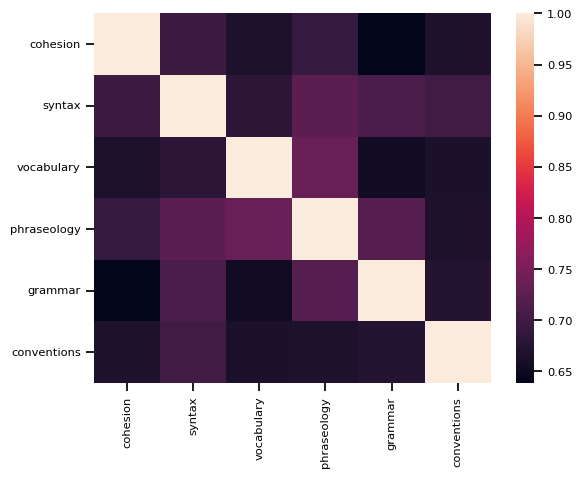

In [7]:
plot_correlations(score_df, TARGET_LIST);

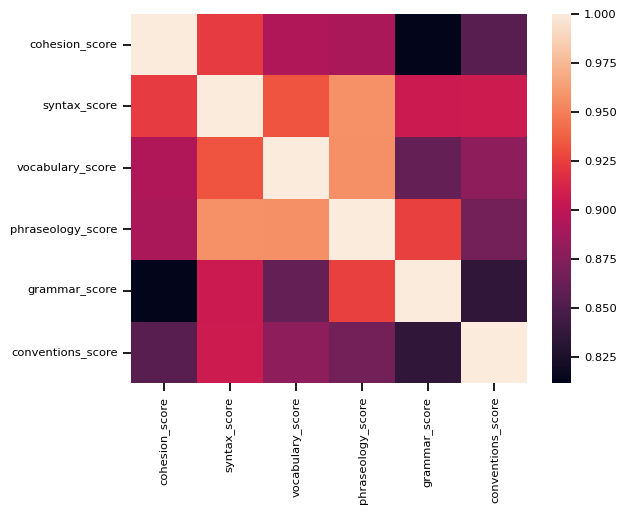

In [8]:
plot_correlations(score_df, [f'{tgt}_score' for tgt in TARGET_LIST]);

In [9]:
def compute_target_rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return math.sqrt(np.power(y_true - y_pred, 2).sum() / y_true.shape[0])

In [10]:
def compute_target_list_rmse(score_df: pd.DataFrame, target_list: t.List[str]):
    target_rmse_list = []
    for target in target_list:
        target_rmse = compute_target_rmse(score_df[target].values, score_df[f'{target}_score'].values)
        target_rmse_list.append(target_rmse)
        print(f'{target.rjust(12)} = {target_rmse:.4f}')
    print(f'{"mean".rjust(12)} = {np.array(target_rmse_list).mean():.4f}')


def compute_rmse_per_fold_and_target(score_df: pd.DataFrame, target_list: t.List, num_folds: int) -> pd.DataFrame:
    row_list = []
    for fold in range(NUM_FOLDS):
        row_list.append({'fold': fold} | {
            target: compute_target_rmse(score_df[score_df['fold'] == fold][target].values, score_df[score_df['fold'] == fold][f'{target}_score'].values)
            for target in target_list
        })
    return pd.DataFrame(row_list)

In [11]:
compute_rmse_per_fold_and_target(score_df, TARGET_LIST, NUM_FOLDS)

,fold,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0,0.473580,0.449089,0.388764,0.445892,0.453158,0.441603
1,1,0.488713,0.442728,0.415672,0.468305,0.461316,0.444779
2,2,0.485103,0.458782,0.407654,0.440526,0.469864,0.449175
3,3,0.468247,0.429764,0.418939,0.449820,0.487304,0.434095
4,4,0.474538,0.431988,0.420238,0.455845,0.471916,0.445869


In [19]:
for target in TARGET_LIST:
    print(
        f'{target.ljust(12)} > 5.0 =',
        len(score_df[score_df[f'{target}_score'] > 5.0]),
        f'{target.ljust(12)} < 0.0 =',
        len(score_df[score_df[f'{target}_score'] < 0.0]))

cohesion     > 5.0 = 0 cohesion     < 0.0 = 0
syntax       > 5.0 = 0 syntax       < 0.0 = 0
vocabulary   > 5.0 = 0 vocabulary   < 0.0 = 0
phraseology  > 5.0 = 0 phraseology  < 0.0 = 0
grammar      > 5.0 = 0 grammar      < 0.0 = 0
conventions  > 5.0 = 0 conventions  < 0.0 = 0


In [20]:
score_df[score_df['cohesion_error'] > 0.25]

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,fold,cohesion_score,...,vocabulary_score,phraseology_score,grammar_score,conventions_score,cohesion_error,syntax_error,vocabulary_error,phraseology_error,grammar_error,conventions_error
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1.0,2.855740,...,3.219144,3.222088,3.093439,2.753647,0.644260,0.549046,0.219144,0.222088,0.906561,0.246353
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0.0,2.784366,...,2.870578,2.740792,2.370473,2.674716,0.284366,0.148692,0.129422,0.740792,0.370473,0.174716
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3.0,3.728123,...,3.628602,3.638128,3.864970,3.887407,0.771877,0.860252,0.871398,0.861872,0.135030,1.112593
5,004AC288D833,"Dear Principal,\r\n\r\nOur school should have ...",3.5,4.0,4.0,3.5,3.5,4.0,0.0,3.021046,...,3.095807,3.039235,3.006536,3.095795,0.478954,1.054946,0.904193,0.460765,0.493464,0.904205
7,008DDDDD8E8D,I think it's a good idea for the estudnets to ...,2.5,2.5,2.5,2.5,2.5,2.0,1.0,2.930750,...,2.795824,2.634844,2.441279,2.327628,0.430750,0.155177,0.295824,0.134844,0.058721,0.327628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,FFA3D98123DC,I agree that having a positive attitude is the...,2.5,3.0,3.0,3.5,3.5,2.5,1.0,3.197112,...,3.224539,3.454167,3.308514,3.010533,0.697112,0.180249,0.224539,0.045833,0.191486,0.510533
3903,FFA6690BC309,Having activities after school are good ideas ...,4.0,3.5,4.0,3.5,3.5,4.0,4.0,3.510139,...,3.445291,3.375903,3.069963,3.421503,0.489861,0.247128,0.554709,0.124097,0.430037,0.578497
3905,FFCDB2524616,"I agree with Ralph Waldo Emerson's ""\n\nTo be ...",2.5,3.0,3.0,4.0,3.5,3.0,4.0,3.295834,...,3.574296,3.693774,3.702154,3.287555,0.795834,0.463967,0.574296,0.306226,0.202154,0.287555
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,1.0,3.633495,...,3.642017,3.368176,3.160593,3.171683,0.366505,0.639579,0.357983,0.631824,0.339407,0.171683
